In [1]:
# imports
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from pydantic import BaseModel, Field
import os 
import base64
# api key 
load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')

In [2]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [3]:
from PIL import Image
import base64
import io

def get_image_size_and_base64(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return width, height, img_base64





# Example usage
image_path = "sample.png"
width, height, image_base64 = get_image_size_and_base64(image_path)
print(f"Width: {width}, Height: {height}")


Width: 1920, Height: 968


In [4]:
# class coordinates(BaseModel):
#     x: int = Field(..., description="X coordinate of the bounding box")
#     y: int = Field(..., description="Y coordinate of the bounding box")
#     width: int = Field(..., description="Width of the bounding box")
#     height: int = Field(..., description="Height of the bounding box")
# class bounding_boxes(BaseModel):
#     coordinates: list[tuple[int, int, int, int]] = Field(..., description="List of bounding box coordinates in the format (x_min, y_min, x_max, y_max)")



model = ChatOpenAI(model="gpt-4o")


In [8]:
img_path = "sample.png"

sys_msg = "You are an assistant tasked with identifying the exact bounding box coordinates of specific content within a given image. The inputs include the image, the dimensions of the image, and the specific content to locate. Your task is to analyze the image and return the precise coordinates of the bounding box enclosing the specified content."

content = "logo of the company which looks like letter P "

human_msg = f"""
The task is to locate and identify the precise bounding box coordinates of the specified content within the provided image.

Parameters:
- content: {content}
- width: {width}
- height: {height}

Instructions:
1. Carefully analyze the image to identify the exact bounding box that encloses the specified content.
2. Provide the bounding box coordinates in the format [x_min, y_min, x_max, y_max], where:
   - (x_min, y_min) represents the top-left corner of the bounding box.
   - (x_max, y_max) represents the bottom-right corner of the bounding box.
3. Ensure the coordinates are accurate and precisely enclose the specified content.

Note: Precision is critical for this task. Make sure your output is reliable and consistent. provide the coordinates in this format of list.
dont add any preambles or postambles to the output, just the coordinates.
"""

messages = [
    SystemMessage(
        content=sys_msg
    ),
    HumanMessage(
        content=[
        {"type": "text", "text": human_msg},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"},
        },]
    )

]

reponse = model.invoke(messages)



In [9]:
import ast

# Convert the string response to a list of integers
coordinates = ast.literal_eval(reponse.content)

# Convert the list of integers to a list of tuples
bounding_boxes = [(coordinates[i], coordinates[i+1], coordinates[i+2], coordinates[i+3]) for i in range(0, len(coordinates), 4)]

print(bounding_boxes)

[(450, 390, 676, 585)]


In [10]:
from PIL import Image, ImageDraw

def draw_bounding_boxes(image_path, bounding_boxes):
    """
    Draws bounding boxes on the image.

    Parameters:
    - image_path (str): Path to the input image.
    - bounding_boxes (list of tuples): List of bounding box coordinates in the format (x_min, y_min, x_max, y_max).

    Returns:
    - Image object with bounding boxes drawn.
    """
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    # Draw each bounding box
    for box in bounding_boxes:
        draw.rectangle(box, outline="green", width=2)

    return image

# Example usage
image_with_boxes = draw_bounding_boxes(image_path, bounding_boxes)
image_with_boxes.show()

In [15]:
from typing import List, Tuple

#state of the GRAPH
class State(BaseModel):
    original_image_path : str = Field(..., description="original image path")
    image_size: Tuple[int, int] = Field(..., description="height and width of the image")
    content : str = Field(..., description="content to locate in the image")
    latest_image_path : str = Field(..., description="latest image path ")
    latest_review: str = Field(..., description="latest review")
    bounding_boxes: List[Tuple[int, int, int, int]] = Field(..., description="List of bounding box coordinates in the format (x_min, y_min, x_max, y_max)")

In [24]:
# Nodes of the Graph 

def drawer(state):
    width, height = state["image_size"]

    sys_msg = "You are an assistant tasked with identifying the exact bounding box coordinates of specific content within a given image. The inputs include the image, the dimensions of the image, and the specific content to locate. Your task is to analyze the image and return the precise coordinates of the bounding box enclosing the specified content."

    human_msg = f"""
    The task is to just locate and identify the precise bounding box coordinates of the specified content within the provided image.

    Parameters:
    - content: {state["content"]}
    - width: {width}
    - height: {height}

    Instructions:
    1. Carefully analyze the image to identify the exact bounding box that encloses the specified content.
    2. Provide the bounding box coordinates in the format [x_min, y_min, x_max, y_max], where:
    - (x_min, y_min) represents the top-left corner of the bounding box.
    - (x_max, y_max) represents the bottom-right corner of the bounding box.
    3. Ensure the coordinates are accurate and precisely enclose the specified content.
    Note: Precision is critical for this task. Make sure your output is reliable and consistent. provide the coordinates in this format of list.
    dont add any preambles or postambles to the output, just the coordinates.

    Important note : Dont refuse the task, if you are not sure about the bounding box, just provide the best possible bounding box you can find.
    """    

    if not state['latest_review']:
        messages = [
            SystemMessage(content=sys_msg),
            HumanMessage(
            content=[
                {"type": "text", "text": human_msg},
                {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encode_image(state['original_image_path'])}"},
                },
            ]
            )
        ]
    else:

        re_draw = f"""
            The previous bounding boxes provided were: {state["bounding_boxes"]}, but they were deemed incorrect based on the review: {state["latest_review"]}. 
            You are also provided with the image containing these incorrect bounding boxes. 

            Your task is to carefully analyze the review feedback and the image to revise the bounding boxes. 
            Ensure that the new bounding boxes are accurate and fully align with the review. 
            Provide the updated bounding boxes in the format [x_min, y_min, x_max, y_max] for each corrected region.
        """
        messages = [
            SystemMessage(content=sys_msg),
            HumanMessage(
                content=[
                    {"type": "text", "text": human_msg},
  
                ]
            ),
            HumanMessage(
                content=[
                    {"type": "text", "text": re_draw},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{encode_image(state['latest_image_path'])}"},
                    },
                ]
            )
        ]
    response = model.invoke(messages)
    coordinates = ast.literal_eval(response.content)

    coordinates =  [(coordinates[i], coordinates[i+1], coordinates[i+2], coordinates[i+3]) for i in range(0, len(coordinates), 4)]

    state["bounding_boxes"] = coordinates
    print(state["original_image_path"])
    image_with_boxes = draw_bounding_boxes(state["original_image_path"], coordinates)
    image_with_boxes.save("image_with_boxes.png")
    return state 

In [25]:
original_image_path = "sample.png"

initial_state = {
    "original_image_path": original_image_path,
    "image_size": (width, height),
    "content": "company logo which looks like a letter P",
    "latest_image_path": None,
    "latest_review": None,
    "bounding_boxes": [],
}
# initial_state = {'original_image_path': 'sample.png',
#  'image_size': (1920, 968),
#  'content': 'company logo',
#  'latest_image_path': 'image_with_boxes.png',
#  'latest_review': "The provided bounding box coordinates [(317, 254, 542, 393)] do not accurately enclose the company logo. The logo is located to the right of the green box in the image.\n\n### Suggested Correction:\nTo accurately enclose the company logo, the bounding box should be adjusted.\n\nGiven the logo's position, the corrected bounding box coordinates are approximately:\n- [x_min, y_min, x_max, y_max]: [579, 313, 689, 439]\n\nThis adjustment will ensure the bounding box accurately encloses the logo.",
#  'bounding_boxes': [(317, 254, 542, 393)]}

res = drawer(initial_state)
print( res["bounding_boxes"])
image_with_boxes = draw_bounding_boxes("sample.png", res["bounding_boxes"])
image_with_boxes.save("image_with_boxes.png")
image_with_boxes.show()

sample.png


AttributeError: type object 'Image' has no attribute 'open'

In [16]:
res['latest_image_path'] = "image_with_boxes.png"


In [17]:
def reviewer(state):
    width, height = state["image_size"]

    sys_msg = "You are an assistant tasked with reviewing the bounding box coordinates of specific content within a given image. The inputs include the image with bounding box drawen by other assistant, the dimensions of the image, the specific content to locate, and the bounding box coordinates provided by another assistant. Your task is to analyze the image and the provided bounding box coordinates to determine if they are accurate and correctly enclose the specified content."

    human_msg = f"""
    The task is to review the provided bounding box coordinates of the specified content within the provided image.

    Parameters:
    - content: {state["content"]}
    - width: {width}
    - height: {height}
    - bounding boxes: {state["bounding_boxes"]}

    the color of the bounding box is green
    Instructions:
    1. Carefully analyze the image and the provided bounding box coordinates to determine if they accurately enclose the specified content.
    2. If the bounding box coordinates are accurate, just return correct without any explanation.
    3. If the bounding box coordinates are inaccurate, provide feedback on the specific issues and suggest corrections.
    4. Also provide the corrected bounding box coordinates in the format [x_min, y_min, x_max, y_max], if necessary.
    Note: Precision is critical for this task. Make sure your review is accurate and provides clear feedback to the assistant.

    2. If the bounding box coordinates are accurate, just return "correct" without any explanation.
    """

    messages = [
        SystemMessage(content=sys_msg),
        HumanMessage(
            content=[
                {"type": "text", "text": human_msg},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{encode_image(state['latest_image_path'])}"},
                },
            ]
        )
    ]

    response = model.invoke(messages)
    review = response.content

    state["latest_review"] = review
    state["latest_image_path"] = "image_with_boxes.png"

    return state
def switch_case(state):
    if state["latest_review"] == "correct":
        return END
    else:
        return "drawer"

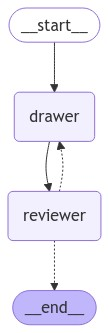

In [18]:
from IPython.display import Image, display

def drawer_g(state):
    width, height = state.image_size

    sys_msg = "You are an assistant tasked with identifying the exact bounding box coordinates of specific content within a given image. The inputs include the image, the dimensions of the image, and the specific content to locate. Your task is to analyze the image and return the precise coordinates of the bounding box enclosing the specified content."

    human_msg = f"""
    The task is to just locate and identify the precise bounding box coordinates of the specified content within the provided image.

    Parameters:
    - content: {state.content}
    - width: {width}
    - height: {height}

    Instructions:
    1. Carefully analyze the image to identify the exact bounding box that encloses the specified content.
    2. Provide the bounding box coordinates in the format [x_min, y_min, x_max, y_max], where:
    - (x_min, y_min) represents the top-left corner of the bounding box.
    - (x_max, y_max) represents the bottom-right corner of the bounding box.
    3. Ensure the coordinates are accurate and precisely enclose the specified content.
    Note: Precision is critical for this task. Make sure your output is reliable and consistent. Provide the coordinates in this format of a list.
    Don't add any preambles or postambles to the output, just the coordinates.

    Important note: Don't refuse the task. If you are not sure about the bounding box, just provide the best possible bounding box you can find.
    """    

    if not state.latest_review:
        messages = [
            SystemMessage(content=sys_msg),
            HumanMessage(
                content=[
                    {"type": "text", "text": human_msg},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{encode_image(state.original_image_path)}"},
                    },
                ]
            )
        ]
    else:
        re_draw = f"""
            The previous bounding boxes provided were: {state.bounding_boxes}, but they were deemed incorrect based on the review: {state.latest_review}. 
            You are also provided with the image containing these incorrect bounding boxes. 

            Your task is to carefully analyze the review feedback and the image to revise the bounding boxes. 
            Ensure that the new bounding boxes are accurate and fully align with the review. 
            Provide the updated bounding boxes in the format [x_min, y_min, x_max, y_max] for each corrected region.
        """
        messages = [
            SystemMessage(content=sys_msg),
            HumanMessage(
                content=[
                    {"type": "text", "text": human_msg},
                ]
            ),
            HumanMessage(
                content=[
                    {"type": "text", "text": re_draw},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{encode_image(state.latest_image_path)}"},
                    },
                ]
            )
        ]

    print(messages)
    response = model.invoke(messages)
    print(response.content)
    coordinates = ast.literal_eval(response.content)

    coordinates = [(coordinates[i], coordinates[i+1], coordinates[i+2], coordinates[i+3]) for i in range(0, len(coordinates), 4)]

    state.bounding_boxes = coordinates
    # image_with_boxes = draw_bounding_boxes(state.original_image_path, coordinates)
    # image_with_boxes.save("image_with_boxes.png")
    # image_with_boxes.show()
    return state

builder = StateGraph(State)
builder.add_node("drawer", drawer_g)
builder.add_node("reviewer", reviewer)

builder.add_edge(START, "drawer")
builder.add_edge("drawer", "reviewer")
builder.add_conditional_edges("reviewer", switch_case)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


[SystemMessage(content='You are an assistant tasked with identifying the exact bounding box coordinates of specific content within a given image. The inputs include the image, the dimensions of the image, and the specific content to locate. Your task is to analyze the image and return the precise coordinates of the bounding box enclosing the specified content.', additional_kwargs={}, response_metadata={}), HumanMessage(content=[{'type': 'text', 'text': "\n    The task is to just locate and identify the precise bounding box coordinates of the specified content within the provided image.\n\n    Parameters:\n    - content: company logo\n    - width: 1920\n    - height: 968\n\n    Instructions:\n    1. Carefully analyze the image to identify the exact bounding box that encloses the specified content.\n    2. Provide the bounding box coordinates in the format [x_min, y_min, x_max, y_max], where:\n    - (x_min, y_min) represents the top-left corner of the bounding box.\n    - (x_max, y_max) 
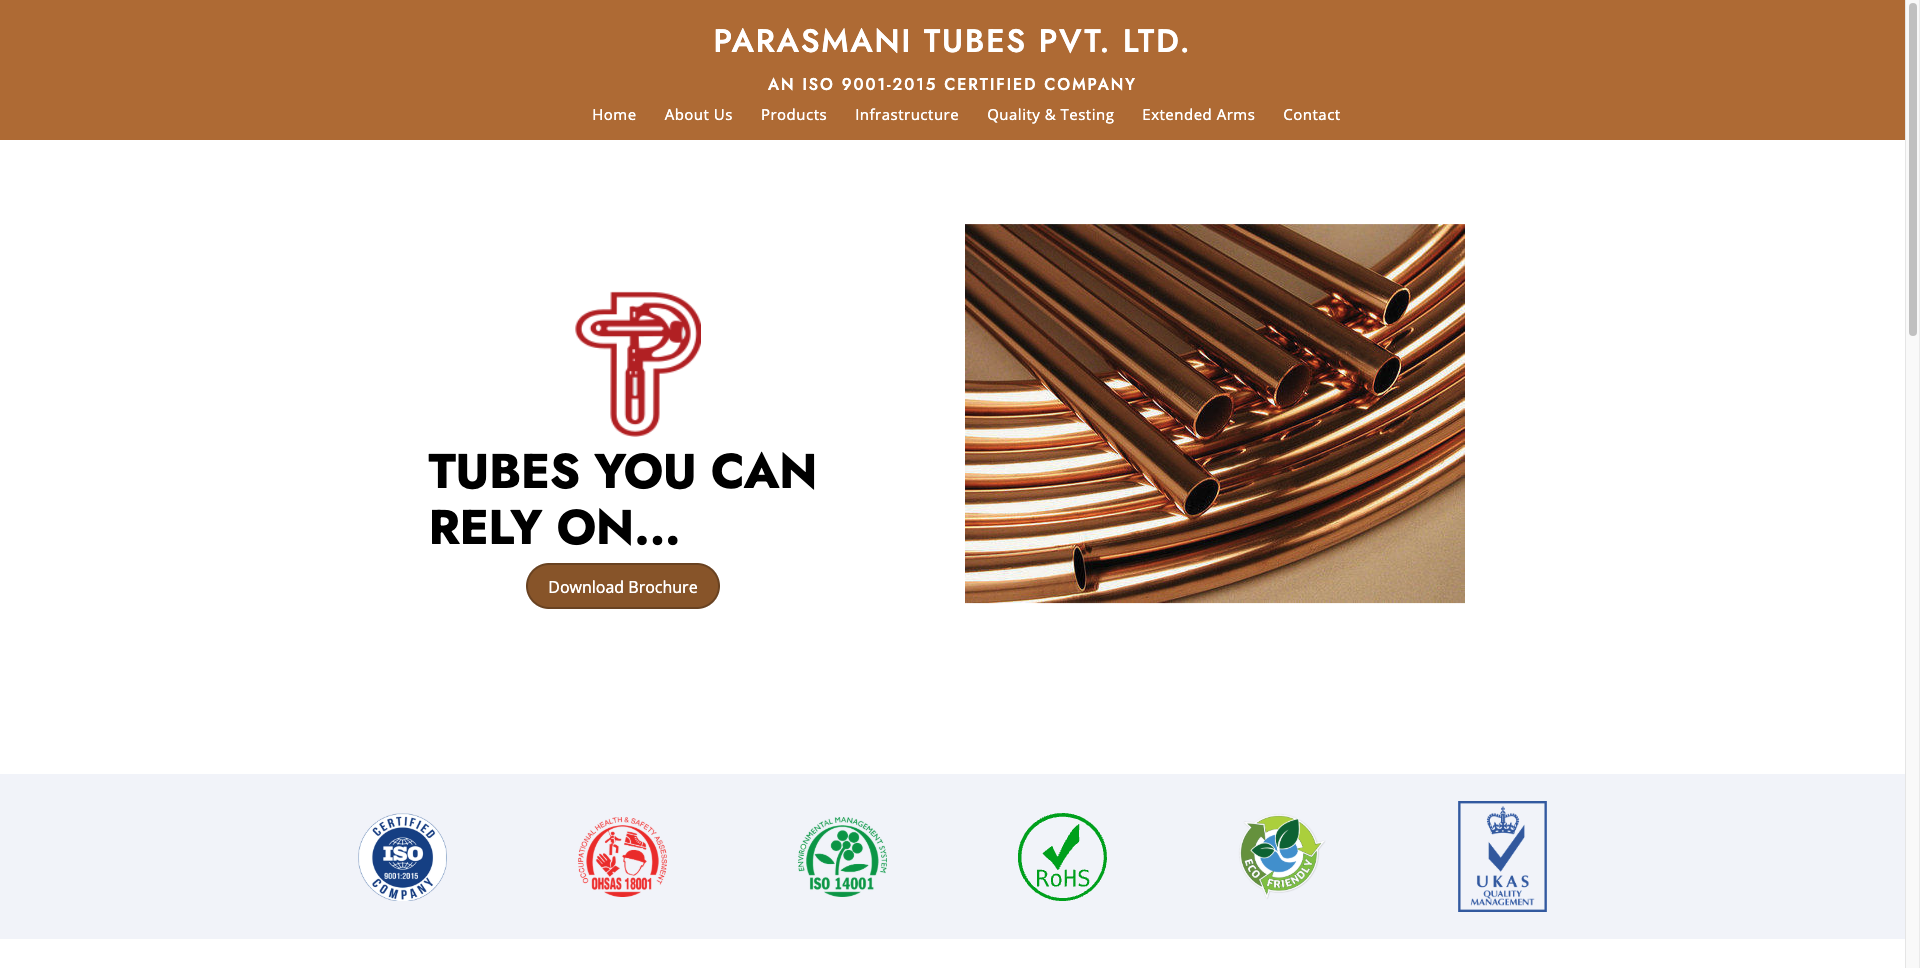

SyntaxError: unterminated string literal (detected at line 1) (<unknown>, line 1)

In [19]:
initial_state = {
    "original_image_path": original_image_path,
    "image_size": (width, height),
    "content": "company logo",
    "latest_image_path": "image_with_boxes.png",
    "latest_review": '',
    "bounding_boxes": [],
}

graph.invoke(initial_state)

In [ ]:
def main_loop(state):
    """
    Main function to recursively improve bounding box coordinates until the reviewer approves them as correct.
    """
    while True:
        # If the bounding boxes are approved as correct, exit the loop
        if state["latest_review"] == "correct":
            print("Bounding box coordinates are correct. Process completed.")
            break

        # Run the drawer function to generate or update bounding boxes
        state = drawer(state)

        # Run the reviewer function to validate the bounding boxes
        state = reviewer(state)

        # Decide the next action based on the review
        action = switch_case(state)

        if action == "END":
            print("Bounding box coordinates are finalized.")
            break
        elif action == "drawer":
            print("Review feedback received. Reiterating...")

    return state
original_image_path = "sample.png"
latest_image_path = "image_with_boxes.png"
initial_state = {
    "original_image_path": original_image_path,
    "image_size": (width, height),
    "content": "company logo which looks like a letter P",
    "latest_image_path": latest_image_path,
    "latest_review": None,
    "bounding_boxes": [],
}
final_state = main_loop(initial_state)